In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from torch.utils.data import DataLoader, Dataset

In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 128)
        self.linear_2 = nn.Linear(128, 256)
        self.linear_3 = nn.Linear(256, 512)
        self.linear2 = nn.Linear(512, 1200)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = F.relu(self.linear_2(z))
        z = F.relu(self.linear_3(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 1200))

class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(1200, 512)
        self.linear_1 = nn.Linear(512, 256)
        self.linear_2 = nn.Linear(256, 128)
        self.linear_3 = nn.Linear(128, 64)
        self.linear_4 = nn.Linear(64, 32)
        self.linear2 = nn.Linear(32, latent_dims)
        self.linear3 = nn.Linear(32, latent_dims)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc # hack to get sampling on the GPU
        self.N.scale = self.N.scale
        self.kl = 0
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear_1(x))
        x = F.relu(self.linear_2(x))
        x = F.relu(self.linear_3(x))
        x = F.relu(self.linear_4(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape).to(device)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    
class DiasTimeSeriesDataset(Dataset):
    """

       Defines the custom DIAS pytorch dataset

    """

    def __init__(self, time_series, labels: any = None, normalise: bool = True):
        self.X = time_series
        self.y = labels

        if normalise:

            self.normalise_data()

    def __len__(self):

        return len(self.X)

    def __getitem__(self, index):

        data = self.X[index, :]

        if self.y is not None:

            return (data, self.y[index])

        else:

            return (data)

    def normalise_data(self):
        
        offset = 0.5

        for idx in range(self.X.shape[0]):
            self.X[idx, :] -= self.X[idx, :].mean()
            # data /= data.std()

            max_value = np.max(np.abs(self.X[idx, :][0, 10:50]))

            # normalise the data
            self.X[idx, :] = (self.X[idx, :] / max_value) * 0.2 + offset



In [4]:
input_dict = {"learn_data": "train_master.npy",
              "learn_labels": "labels_master.npy",
}
cut_off = 4136
# load learning and test data
learn_data = np.load(input_dict["learn_data"])
learn_labels = np.load(input_dict["learn_labels"])

# find just the good data
index_good = learn_labels == 0

learn_data = learn_data[index_good]
learn_labels = learn_labels[index_good]

# dataloaders
learn_data_ = np.reshape(

    learn_data,
    (learn_data.shape[0],
     1,
     learn_data.shape[1]
     )

 )


train_data = DiasTimeSeriesDataset(

    learn_data_[:cut_off],
    labels=learn_labels[:cut_off]

)
test_data = DiasTimeSeriesDataset(

    learn_data_[cut_off:],
    labels=learn_labels[cut_off:]

)

labels_text = ('good', 'sample', 'variable', 'em', 'contact', 'transient', 'disconnect', 'bad')

# data loaders
train_loader = DataLoader(train_data, batch_size=500, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=True)

In [5]:
def train(autoencoder, train_loader, epochs=1000):
    opt = torch.optim.Adam(autoencoder.parameters())
    # loss_fun = torch.nn.CrossEntropyLoss()
    for epoch in range(epochs):
        for i, data in enumerate(train_loader, 0):

            # get the inputs; data is a list of [inputs, labels]
            x, y = data
            y = y.to(device)
            x = x.type(torch.float32)
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x).to(device)
            # loss = loss_fun(x, x_hat) + autoencoder.encoder.kl
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()

    return autoencoder

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device, torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))

latent_dims = 2
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, train_loader).to(device)

cpu False


In [8]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        x = x.type(torch.float32)
        z = autoencoder.encoder(x.to(device))
        z = z.cpu().detach().numpy()
#         print(y)
        
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

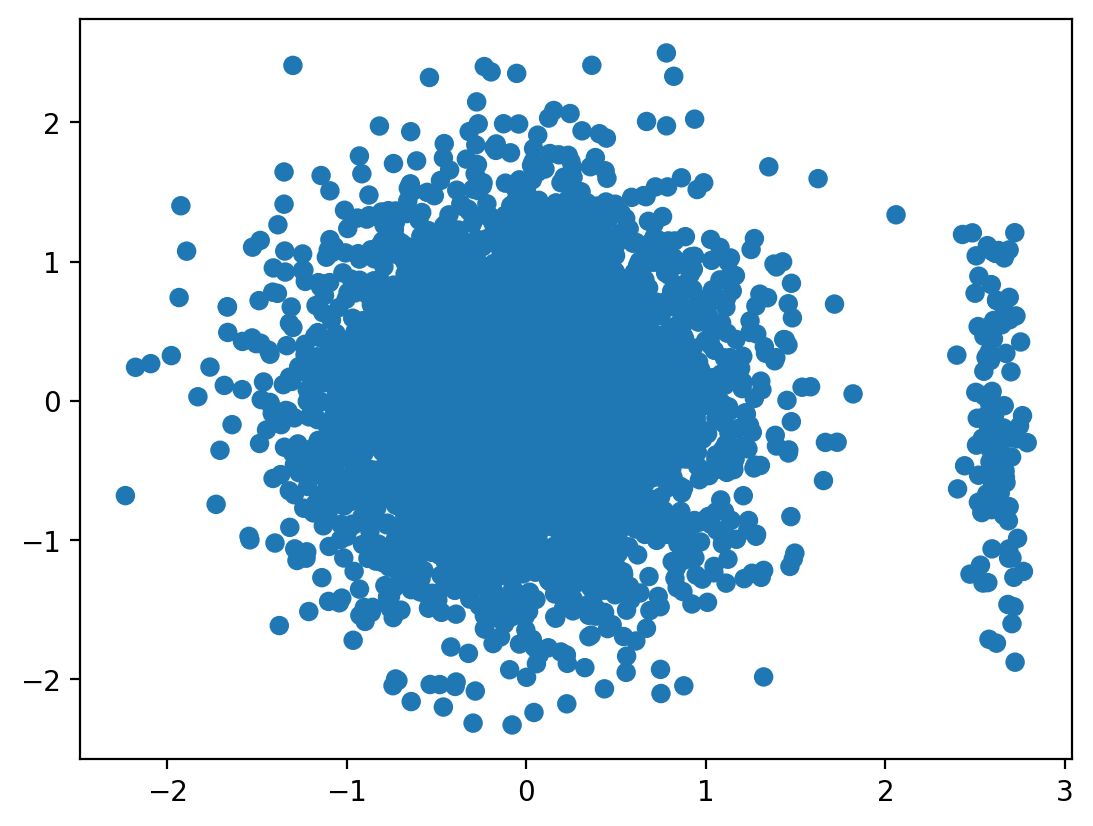

In [9]:
plot_latent(vae, train_loader)

In [10]:
# type(test_data[0][0])
xc = torch.from_numpy(test_data[3][0]).type(torch.float32).to(device)
print(vae(xc).view(1, 1200))

# save the model to disk
# torch.save(vae, 'vae-ts')

tensor([[0.5171, 0.5550, 0.6133,  ..., 0.4985, 0.4994, 0.5028]],
       grad_fn=<ViewBackward0>)


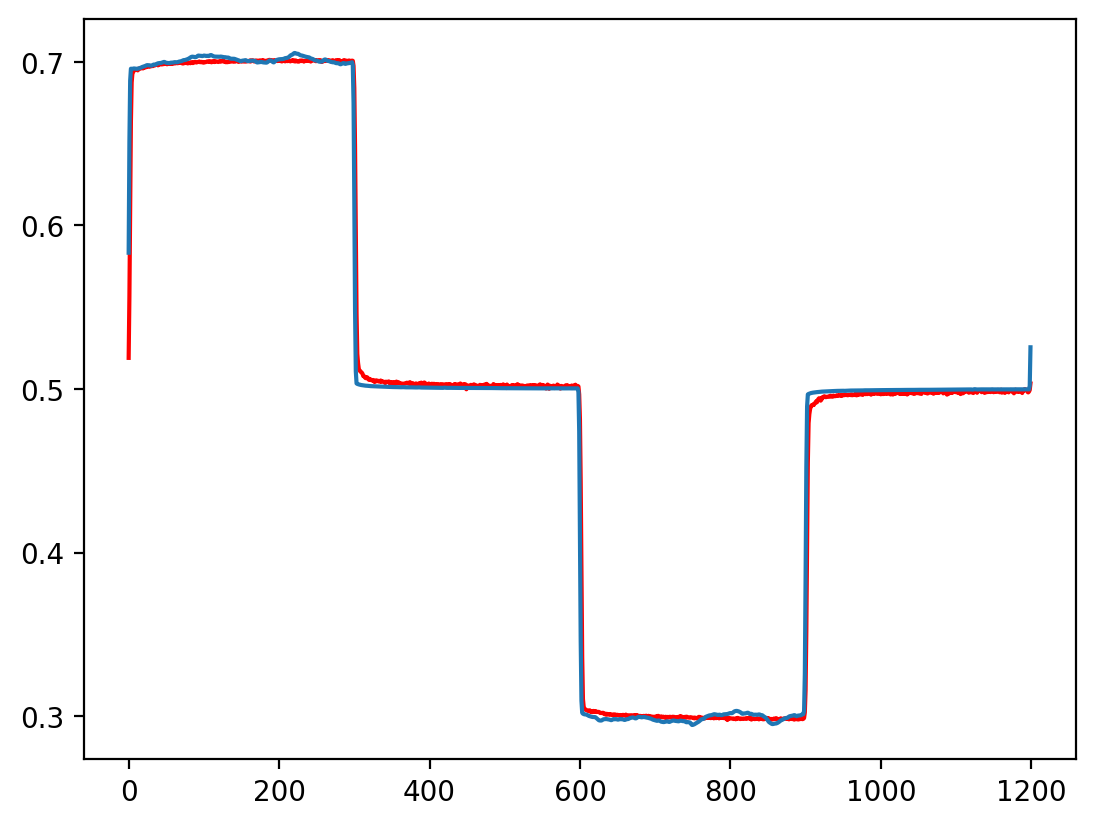

In [11]:
xc.to(device)
plt.plot(vae(xc).view(1, 1200).cpu().detach().numpy()[0,:], 'r')
plt.plot(xc.cpu().detach().numpy()[0,:])
plt.show()

In [12]:
np.linalg.norm(vae(xc).view(1, 1200).cpu().detach().numpy()[0,:] - xc.cpu().detach().numpy()[0,:])

0.31165802

In [13]:

# try with other data
learn_data_ = -np.load(input_dict["learn_data"])
learn_labels_ = np.load(input_dict["learn_labels"])

# find just the good data
index_test = learn_labels_ == 4

learn_data = learn_data_[index_test]
learn_labels = learn_labels_[index_test]
print(index_test.sum())

# dataloaders
learn_data_ = np.reshape(

    learn_data,
    (learn_data.shape[0],
     1,
     learn_data.shape[1]
     )

 )


_test_data = DiasTimeSeriesDataset(

    learn_data_,
    labels=learn_labels

)

115


(1, 1200)


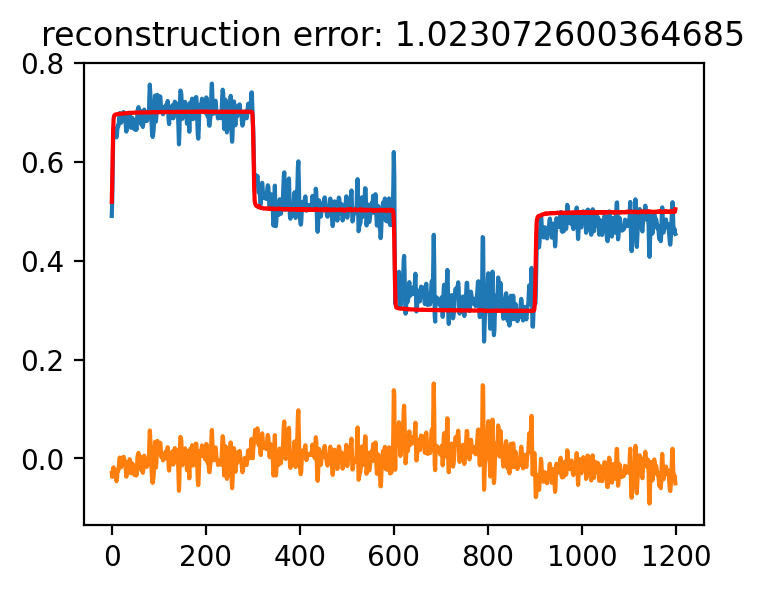

In [56]:
# %matplotlib notebook
xc = torch.from_numpy(_test_data[20][0]).type(torch.float32).to(device)
print(test_data[20][0].shape)
# print(vae(xc).view(1, 1200).detach().numpy()[0, :])
plt.figure(figsize=(4,3))
plt.plot(xc.cpu().detach().numpy()[0,:])
plt.plot(vae(xc).view(1, 1200).cpu().detach().numpy()[0, :], 'r')
plt.plot(xc.cpu().detach().numpy()[0,:] - vae(xc).view(1, 1200).cpu().detach().numpy()[0, :])
plt.title(f"reconstruction error: {np.linalg.norm(vae(xc).view(1, 1200).cpu().detach().numpy()[0,:] - xc.cpu().detach().numpy()[0,:])}")
plt.show()

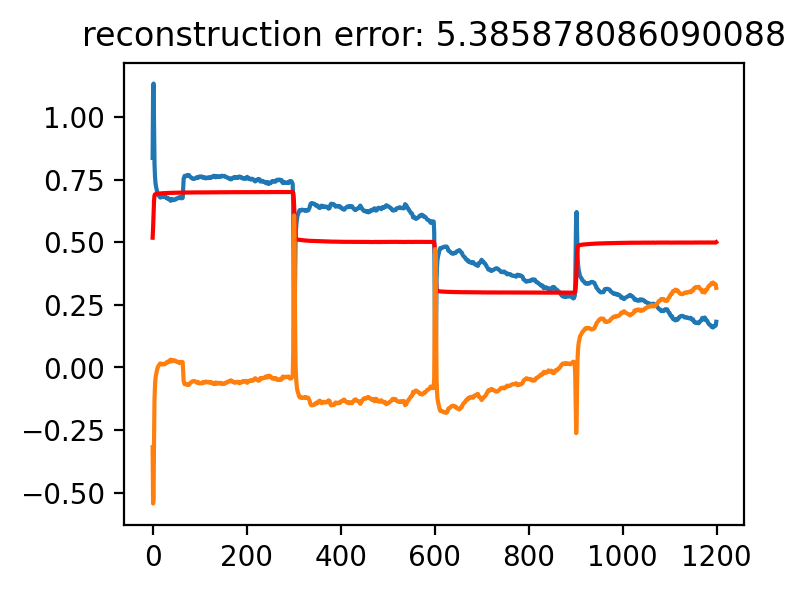

In [15]:
# try with other data
test_data = -np.load('test_bad_timeseries2.npy')
# test_labels = np.zeros_like(learn_data.shape[1])

# dataloaders
test_data_ = np.reshape(

    test_data,
    (test_data.shape[0],
     1,
     test_data.shape[1]
     )

 )


_test_data = DiasTimeSeriesDataset(

    test_data_,
    # labels=test_labels

)

xc = torch.from_numpy(_test_data[0]).type(torch.float32).to(device)
plt.figure(figsize=(4,3))
plt.plot(xc.cpu().detach().numpy()[0,:])
plt.plot(vae(xc).view(1, 1200).cpu().detach().numpy()[0, :], 'r')
plt.plot(vae(xc).view(1, 1200).cpu().detach().numpy()[0, :] - xc.cpu().detach().numpy()[0,:])
plt.title(f"reconstruction error: {np.linalg.norm(vae(xc).view(1, 1200).cpu().detach().numpy()[0,:] - xc.cpu().detach().numpy()[0,:])}")
plt.show()


In [61]:
10 * 10

100

## tests with field data

In [94]:
from scipy import signal as sig
from datfiles_lib_parallel import *
from os import listdir
dir_path_dc = r"C:\Users\johnk\Documents\projects\ubc\cpsc540\projects\report\johnsift\\"
only_files = [f for f in listdir(dir_path_dc)]     # gets files # remember 8
# print(only_files)
idx = 0

reconstruction_errors = []

receiver_dict = {}

for idx in range(len(only_files)):
    
    if only_files[idx].split(".")[-1] == "DAT":
        
        node = dir_path_dc + only_files[idx]
        
        receiver_dict[node.split('.')[0]] = {
            
            'std': None,
            'reconstruction_error': []
        
        }
#         print(node)
        fIn = open(node, 'r', encoding="utf8", errors=""'ignore')
        linesFIn = fIn.readlines()
        fIn.close()

        time, data = read_data(linesFIn)
        
        # stack the data
        num_half_T = int(np.floor(data.size / 1200))
        new_trim = int(num_half_T * 1200)
        xt_data = data[:new_trim]
        
        xt_data = np.reshape(xt_data, (1200, num_half_T), order='F')
        # print(xt_data.shape)

        offset = 0.5

        time_series_reconstruction = []

        for idx in range(xt_data.shape[1]):

            xt_data[:, idx] -= xt_data[:, idx].mean()
            # data /= data.std()

            max_value = np.max(np.abs(xt_data[10:50, idx]))

            # normalise the data
            xt_data[:, idx] = (xt_data[:, idx] / max_value) * 0.2 + offset

            xc = torch.from_numpy(xt_data[:, 0]).type(torch.float32).to(device)

            reconstruction = vae(xc.view(1, 1200)).cpu().detach().numpy()[0, :]

            error = np.linalg.norm(vae(xc.view(1, 1200)).cpu().detach().numpy()[0,:] - xc.view(1, 1200).cpu().detach().numpy()[0, :])

            time_series_reconstruction.append(reconstruction)
            receiver_dict[node.split('.')[0]]['reconstruction_error'].append(error)
            reconstruction_errors.append(error)

        xc_data = np.hstack(time_series_reconstruction)

        # noise estimation
        delta_ts = xt_data.flatten(order='F') - xc_data[0, :]

        receiver_dict[node.split('.')[0]]['std'] = np.std(delta_ts)


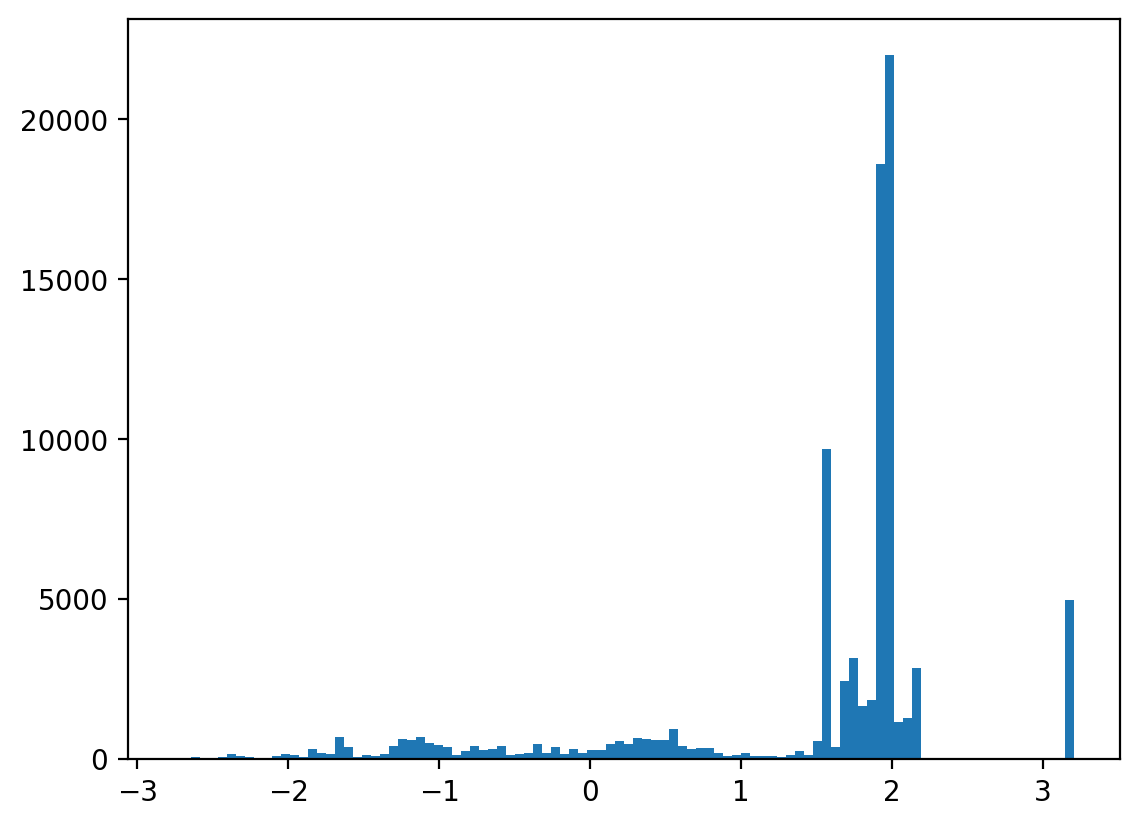

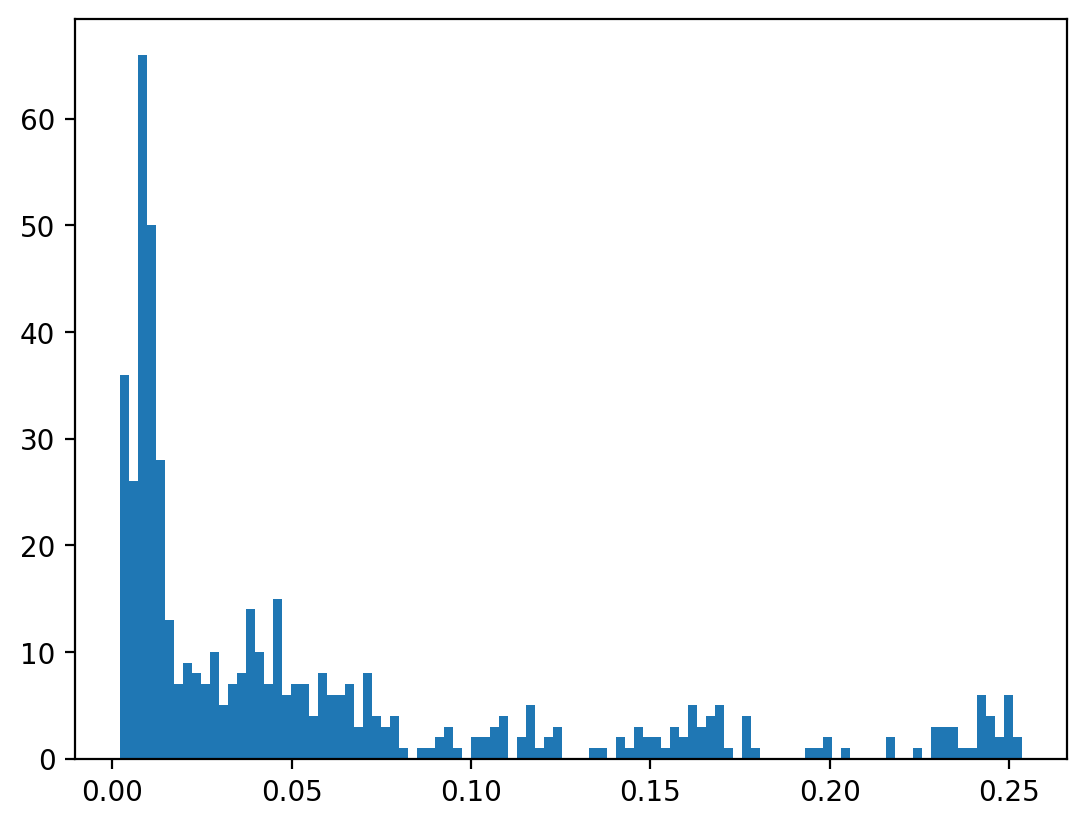

In [98]:
# import json
# with open('rxdata.json', 'w') as fp:
#     json.dump(receiver_dict, fp)
plt.hist(np.log(reconstruction_errors), 100)
plt.show()

stds = []

for key in receiver_dict.keys():

    stds.append(receiver_dict[key]['std'])

plt.hist(stds, 100)
plt.show()

In [87]:
node = dir_path_dc + only_files[idx]
#         print(node)
fIn = open(node, 'r', encoding="utf8", errors=""'ignore')
linesFIn = fIn.readlines()
fIn.close()

time, data = read_data(linesFIn)

# stack the data
num_half_T = int(np.floor(data.size / 1200))
new_trim = int(num_half_T * 1200)
xt_data = data[:new_trim]

xt_data = np.reshape(xt_data, (1200, num_half_T), order='F')
# print(xt_data.shape)

offset = 0.5

idx = 0

time_series_reconstruction = []
reconstruction_error = []

for idx in range(xt_data.shape[1]):

    xt_data[:, idx] -= xt_data[:, idx].mean()
    # data /= data.std()

    max_value = np.max(np.abs(xt_data[10:50, idx]))

    # normalise the data
    xt_data[:, idx] = (xt_data[:, idx] / max_value) * 0.2 + offset

    xc = torch.from_numpy(xt_data[:, 0]).type(torch.float32).to(device)

    reconstruction = vae(xc.view(1, 1200)).cpu().detach().numpy()[0, :]

    error = np.linalg.norm(vae(xc.view(1, 1200)).cpu().detach().numpy()[0,:] - xc.view(1, 1200).cpu().detach().numpy()[0, :])

    time_series_reconstruction.append(reconstruction)
    reconstruction_error.append(error)

xc_data = np.hstack(time_series_reconstruction)

print(xc_data.shape, xt_data.shape)

(1, 32400) (1200, 27)


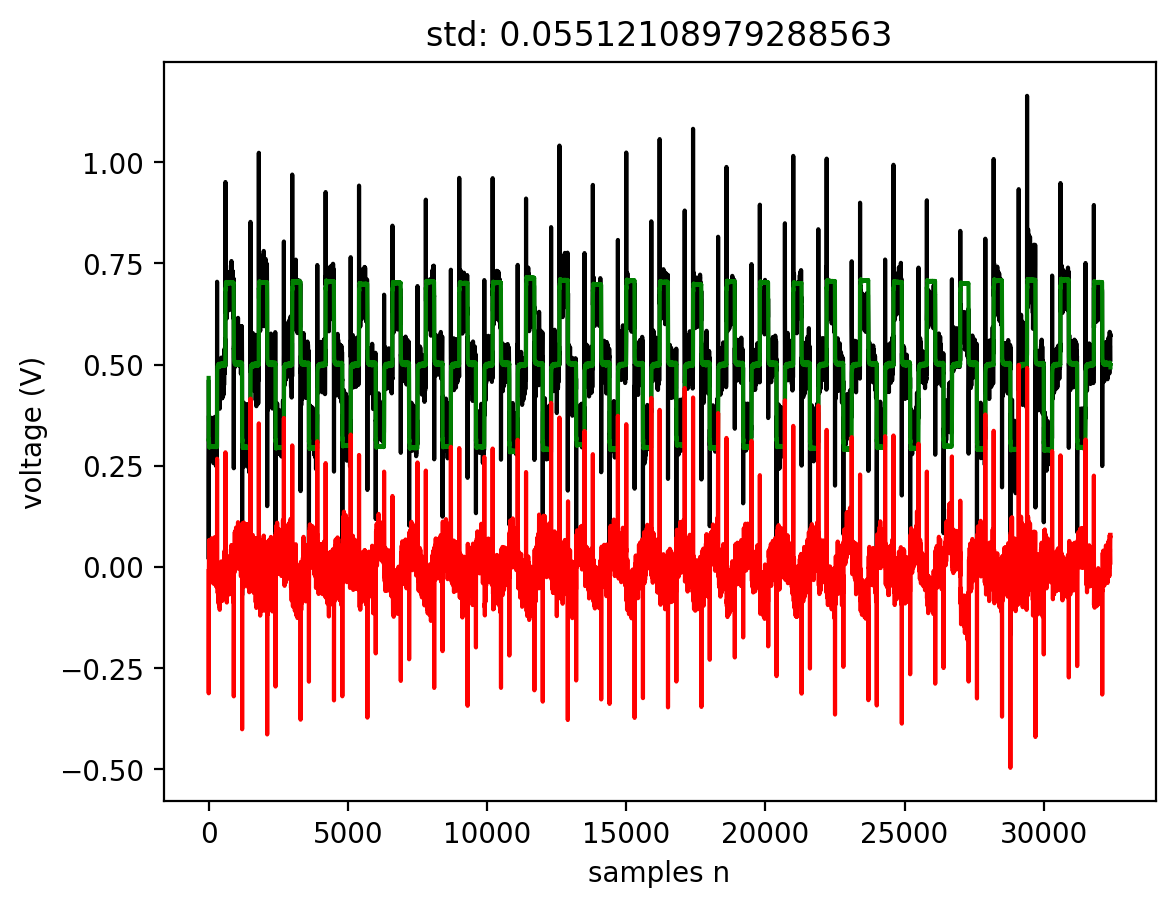

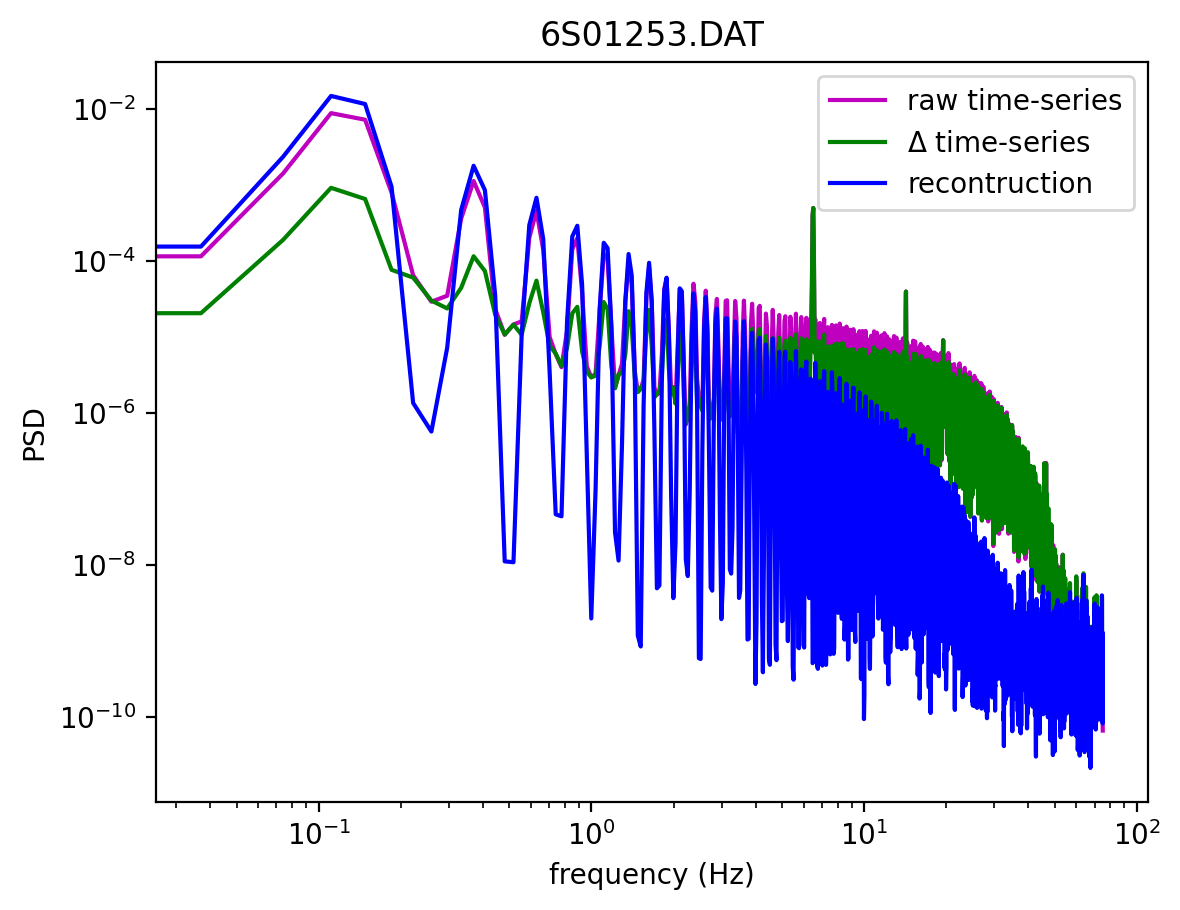

In [93]:
plt.plot(xt_data.flatten(order='F'), 'k')
plt.plot(xc_data[0, :], 'g')
plt.plot(xt_data.flatten(order='F') - xc_data[0, :], 'r')
plt.xlabel('samples n')
plt.ylabel('voltage (V)')
plt.title(f"std: {np.std(xt_data.flatten(order='F') - xc_data[0, :])}")
plt.show()

plt.figure()
f, psd = sig.welch(xt_data.flatten(order='F'), fs=150, window='blackman', nperseg=4056, scaling='spectrum')
plt.loglog(f, psd, 'm', label='raw time-series')
f, psd = sig.welch(xt_data.flatten(order='F') - xc_data[0, :], fs=150, window='blackman', nperseg=4056, scaling='spectrum')
plt.loglog(f, psd, 'g', label='$\Delta$ time-series')
f, psd = sig.welch(xc_data[0, :], fs=150, window='blackman', nperseg=4056, scaling='spectrum')
plt.loglog(f, psd, 'b', label='recontruction')
plt.legend()

plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')

plt.title(node.split('\\')[-1])
plt.show()

## Process some data

half T: 54.0 window: 54 Kernel: 54
0.0022237644689934487
-0.0033898810011416137


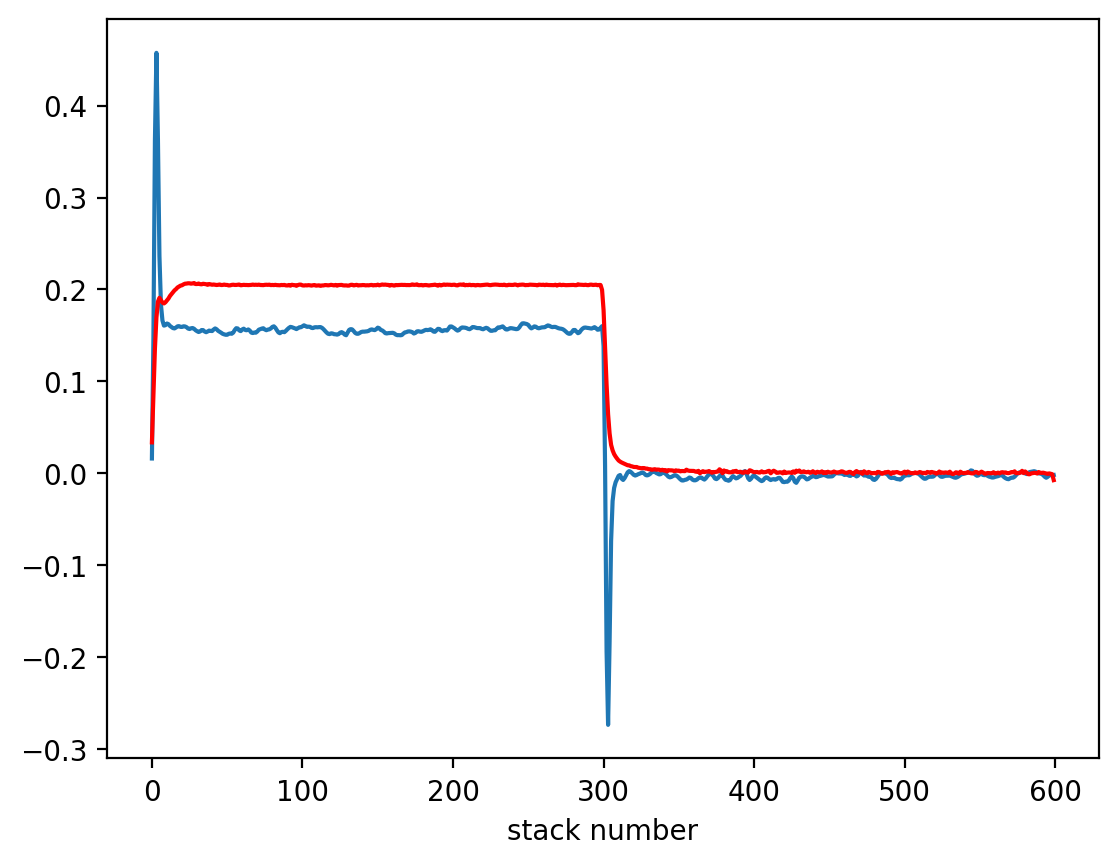

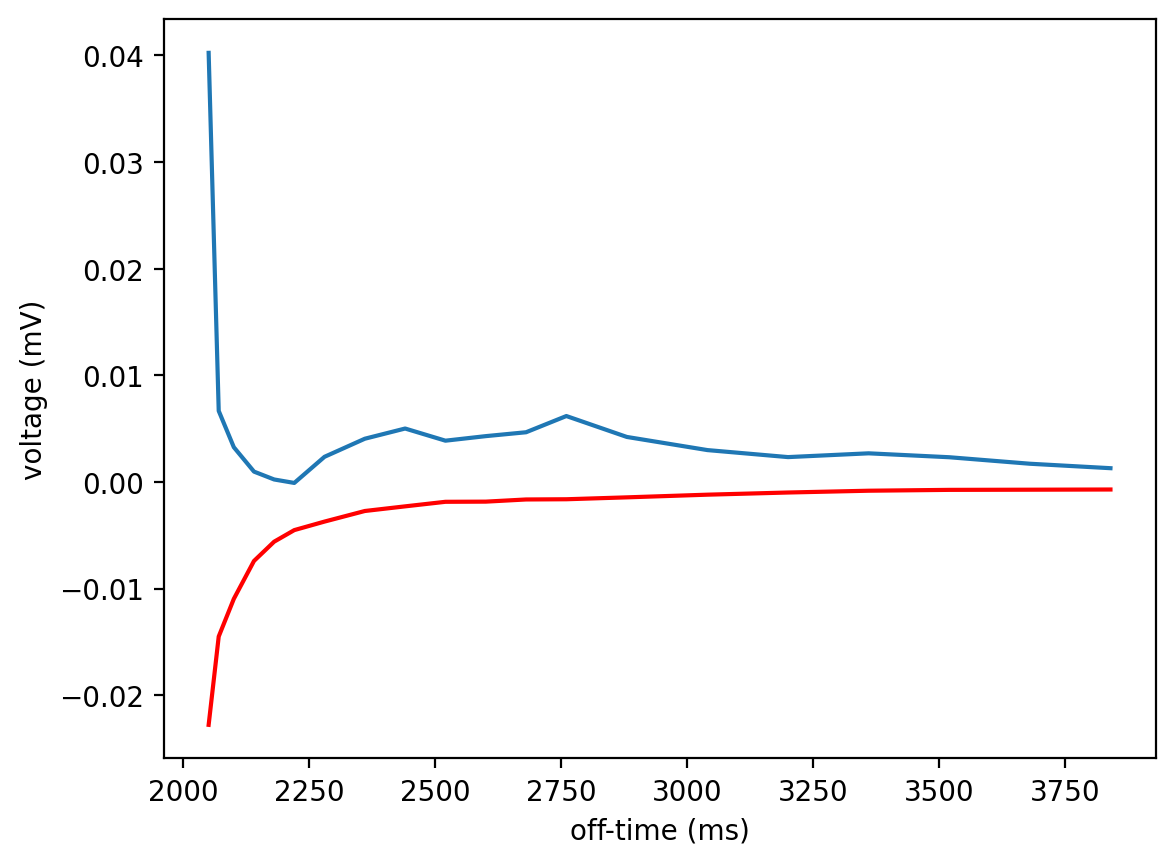

In [86]:
# ---------------------------------------------------------------------------

# Code snippit for processing dciptimeseries data

# ----------------------------------------------------------------------------

import EMtools as DCIP
# import matplotlib.pyplot as plt

def getTime():
    timeFrom = [2040., 2060., 2080., 2120., 2160., 2200.,
                2240., 2320., 2400.,
                2480., 2560., 2640.,
                2720., 2800., 2960.,
                3120., 3280., 3440.,
                3600., 3760.]
    timeTo = [2060., 2080., 2120., 2160., 2200., 2240.,
              2320., 2400., 2480., 2560., 2640., 2720.,
              2800., 2960., 3120., 3280., 3440.,
              3600., 3760., 3920.]
    return timeFrom, timeTo

# ----------------------------------------------------------------------------

# stack the data 

#

timeFrom, timeTo = getTime()

mid_time = (np.asarray(timeTo) + np.asarray(timeFrom)) / 2
time_width = np.asarray(timeTo) - np.asarray(timeFrom)

num_half_T = np.floor(xt_data.flatten(order='F').size / 600)
new_trim = int(num_half_T * 600)

xt_data = xt_data.flatten(order='F')[:new_trim]
xc_data = xc_data[0, :][:new_trim]

start_vp = 50                           # start of Vp calculation (%)
end_vp = 90                             # end of Vp calculation (%)
window = DCIP.createHanningWindow(num_half_T)   # creates filter window
# window = DCIP.createChebyshevWindow(int(num_half_T), 500)
window2 = DCIP.createKaiserWindow(int(num_half_T), 150)

tHK = DCIP.filterKernel(filtershape=window)     # creates filter kernal
tHK2 = DCIP.filterKernel(filtershape=window)     # creates filter kernal
print("half T: {0} window: {1} Kernel: {2}".format(num_half_T, window.size, tHK.kernel.size))
# print(xt.size)
# # eHK = DCIP.ensembleKernal(filtershape=window3,
# #                           number_half_periods=num_half_T)
dkernal = DCIP.decayKernel(num_windows=np.asarray(timeTo).size,
                           window_starts=np.asarray(timeFrom),
                           window_ends=np.asarray(timeTo),
                           window_weight=501,
                           window_overlap=0.99,
                           output_type="Vs")  # creates decay kernal
stack = tHK * -xt_data                               # stack data
stack2 = tHK * -xc_data                               # stack data

decay = dkernal * (tHK * xt_data)         # calculates the decay
decay2 = dkernal * (tHK * xc_data)         # calculates the decay

print(np.sum(-decay2 * time_width) / np.sum(time_width))
print(np.sum(-decay * time_width) / np.sum(time_width))

# ----------------------------------------------------------------------------

# plot data

#

plt.figure()
plt.plot(stack)
plt.plot(stack2, 'r')
plt.xlabel("stack number")
plt.show()
plt.figure()
plt.plot(mid_time, decay)
plt.plot(mid_time, decay2, 'r')
plt.ylabel("voltage (mV)")
plt.xlabel("off-time (ms)")
plt.show()
